# Анализ таблиц в базе данных "Регистрация участников на фестиваль"

## Импорт библиотек и объявление переменных для подключения к БД

In [1]:
import psycopg2
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set(style="whitegrid", font_scale=1.3, palette="Set2")

In [6]:
dbname = "..."
user = "..."
password = "..."
host = "..."
port = ...

## Анализ графиков

### Анализ таблицы `transfer`

Скопируем таблицу в DataFrame.

In [12]:
conn = psycopg2.connect(
    dbname=dbname, user=user, password=password, host=host, port=port
)
cursor = conn.cursor()

sql_query = pd.read_sql_query(
    """
    SELECT *
    FROM fest.transfer
    """,
    conn,
)
data = pd.DataFrame(sql_query, columns=["train", "route_train", "capacity"])

cursor.close()
conn.close()

data.head()

/tmp/ipykernel_1379116/4044876410.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  sql_query = pd.read_sql_query(


,train,route_train,capacity
0,100,Vladivostok,144
1,101,Saint-Petersburg,51
2,102,Sochi,118
3,103,Vladivostok,61
4,104,Samara,160


Построим на некоторые статистики вместимости поездов в зависимости от направления.

In [13]:
capacity_sum = (
    data[["route_train", "capacity"]].groupby(by=["route_train"]).sum()
)
capacity_mean = (
    data[["route_train", "capacity"]].groupby(by=["route_train"]).mean()
)

Text(0.5, 0, 'Направление')

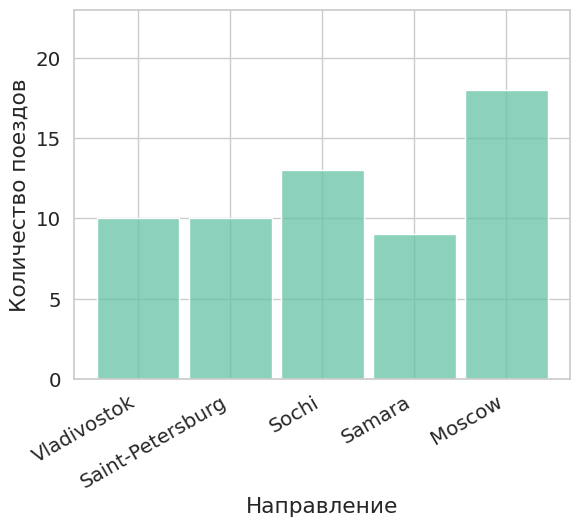

In [22]:
sns.histplot(data=data, x="route_train", shrink=0.9)
plt.xticks(rotation=30, ha="right")
plt.ylim((0, 23))
plt.ylabel("Количество поездов")
plt.xlabel("Направление")

Text(0.5, 0, 'Направление')

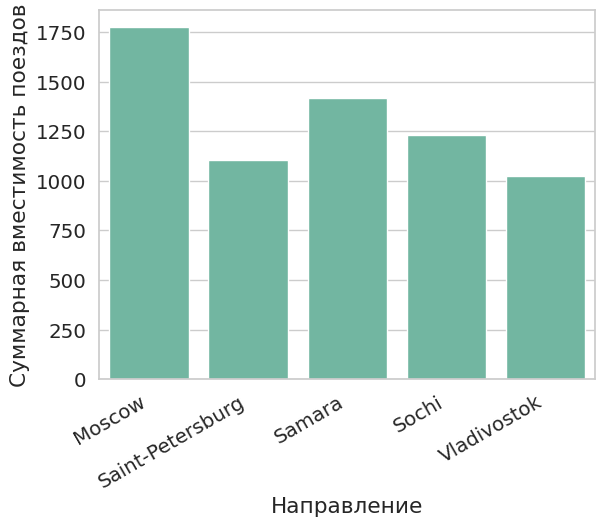

In [23]:
sns.barplot(data=capacity_sum, x="route_train", y="capacity")
plt.xticks(rotation=30, ha="right")
plt.ylabel("Суммарная вместимость поездов")
plt.xlabel("Направление")

Text(0.5, 0, 'Направление')

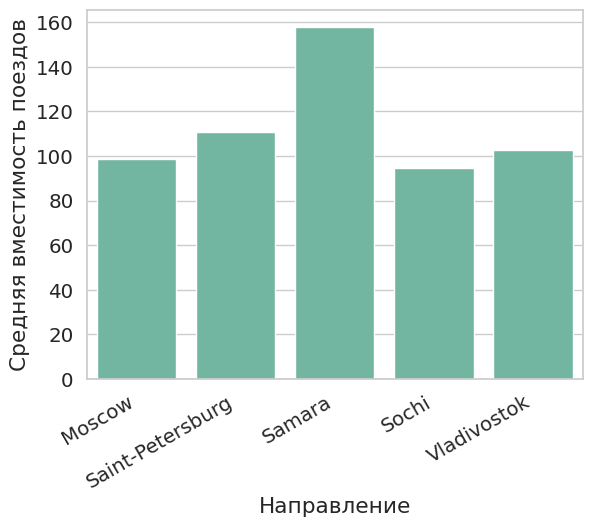

In [24]:
sns.barplot(data=capacity_mean, x="route_train", y="capacity")
plt.xticks(rotation=30, ha="right")
plt.ylabel("Средняя вместимость поездов")
plt.xlabel("Направление")

**Вывод:** из исследования можно сделать вывод, что поездов больше всего из Москвы. Самая большая средняя вместимость у поездов из Самары. Закономерно, суммарная вместимость будет больше именно на этих маршрутах. 

### Анализ запросов

#### Распределение участников по сферам работы

Для этого пункта модифицируем запрос "1. ФИО каждого участника и сфера, в которой он работает" к БД. Далее построим график зависимости количества людей в сфере от самой сферы.

In [33]:
conn = psycopg2.connect(
    dbname=dbname, user=user, password=password, host=host, port=port
)
cursor = conn.cursor()

sql_query = pd.read_sql_query(
    """
    SELECT sex, field
    FROM fest.participants p
    INNER JOIN fest.organizations o
    ON p.org_id = o.org;
    """,
    conn,
)
data = pd.DataFrame(sql_query, columns=["sex", "field"])
sns.histplot(data=data, x="field", hue="sex", shrink=0.9)
plt.xticks(rotation=30, ha="right")
plt.ylabel("Количество участников")
plt.xlabel("Сфера деятельности")
plt.legend(labels=["Мужчины", "Женщины"])
cursor.close()
conn.close()

data.head()

/tmp/ipykernel_1379116/2814064426.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  sql_query = pd.read_sql_query(


,sex,field
0,True,Manufacturing
1,True,Manufacturing
2,False,Business
3,False,Manufacturing
4,True,Science


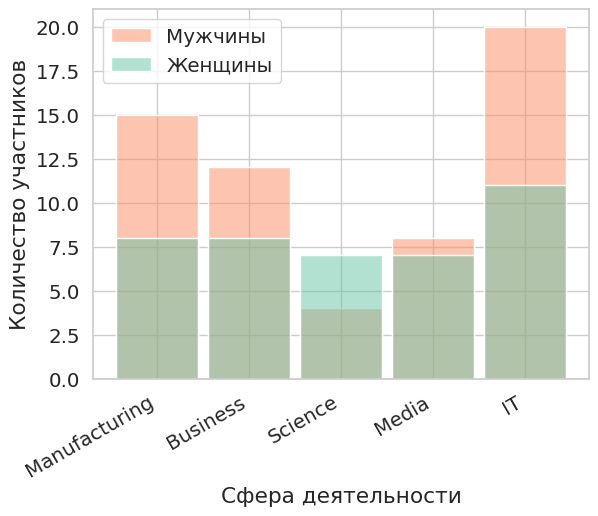

In [39]:
sns.histplot(data=data, x="field", hue="sex", shrink=0.9)
plt.xticks(rotation=30, ha="right")
plt.ylabel("Количество участников")
plt.xlabel("Сфера деятельности")
plt.legend(labels=["Мужчины", "Женщины"])

**Вывод:** больше всего людей работают в IT или занимаются промышленностью. Причём этими сферами заинтересованы в основном мужчины. Наукой и медиа заинтересованы меньшенство, однако в науке работают больше женщин.

#### Распределение участников по типам размещения

Для этого пункта модифицируем запрос "9. Количество людей в каждом варианте размещения" к БД. Далее построим график зависимости количества людей в типах размещения от самого типа.

In [41]:
conn = psycopg2.connect(
    dbname=dbname, user=user, password=password, host=host, port=port
)
cursor = conn.cursor()

sql_query = pd.read_sql_query(
    """
    SELECT a.type_acc, p.passport, p.sex
    FROM fest.accommodation a
    INNER JOIN fest.participants p
    ON p.accommodation_id = a.id;
    """,
    conn,
)
data = pd.DataFrame(sql_query, columns=["type_acc", "passport", "sex"])

cursor.close()
conn.close()

data.head()

/tmp/ipykernel_1379116/2092086056.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  sql_query = pd.read_sql_query(


,type_acc,passport,sex
0,Villa,7956822861,True
1,Villa,2524733465,True
2,Hostel,3483174990,False
3,Hostel,8528236693,False
4,Villa,2897510346,True


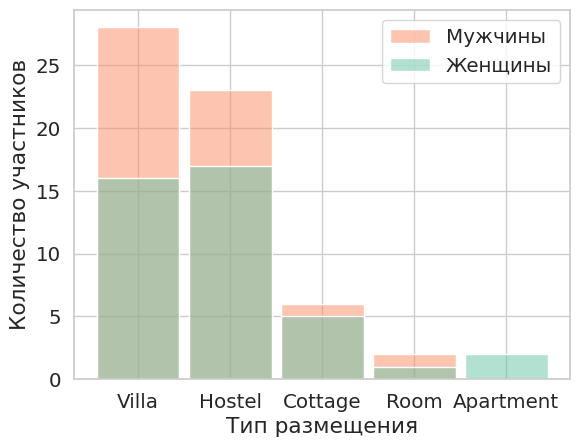

In [44]:
sns.histplot(data=data, x="type_acc", hue="sex", shrink=0.9)
plt.ylabel("Количество участников")
plt.xlabel("Тип размещения")
plt.legend(labels=["Мужчины", "Женщины"])

**Вывод:** большинство людей живут в виллах и хостелах. Также по графику можно сказать, что количество мужчин на фестивале превышает количество женщин. Тем не менее, несколько участниц занимают апартаменты, где не живут мужчины.